In [1]:
import os
from dotenv import load_dotenv
load_dotenv()                           # expects .env in the repo root

OPENAI_API_KEY  = os.getenv("OPENAI_API_KEY")
PINECONE_API_KEY = os.getenv("PINECONE_API_KEY")
PINECONE_ENV     = os.getenv("PINECONE_ENV")  # e.g. "gcp-starter"


In [ ]:
from pathlib import Path
import fitz  # PyMuPDF

def load_pdf(path: Path) -> str:
    doc = fitz.open(path)
    text = []
    for page in doc:
        text.append(page.get_text("text"))
    return "\n".join(text)

raw_text = load_pdf(Path("/Users/rajeev/Downloads/doc2.pdf"))
print(raw_text[:1000])   # sanity‑check first 1 000 chars


In [3]:
import os, base64
from pathlib import Path
from tqdm import tqdm

import fitz                         # PyMuPDF 2.0+
import tabula                       # needs Java;  pip install tabula-py jpype1
from langchain.text_splitter import RecursiveCharacterTextSplitter


In [ ]:
# def create_directories(base_dir: str = "data"):
#     for leaf in ["images", "text", "tables", "page_images"]:
#         os.makedirs(Path(base_dir) / leaf, exist_ok=True)


In [ ]:
# def process_tables(filepath: str, doc, page_num: int, base_dir: str, items: list):
#     """Extract all tables on a page with Tabula → save as txt."""
#     try:
#         tables = tabula.read_pdf(filepath, pages=page_num + 1, multiple_tables=True)
#         if not tables:
#             return
#         for t_idx, df in enumerate(tables):
#             table_text = "\n".join([" | ".join(map(str, row)) for row in df.values])
#             fname = Path(base_dir) / "tables" / f"{Path(filepath).stem}_table_{page_num}_{t_idx}.txt"
#             fname.write_text(table_text, encoding="utf-8")
#             items.append({"page": page_num, "type": "table", "text": table_text, "path": str(fname)})
#     except Exception as e:
#         print(f"[warn] page {page_num}: table extract failed ➜ {e}")

# def process_text_chunks(text: str, splitter, page_num: int, base_dir: str, filepath: str, items: list):
#     for i, chunk in enumerate(splitter.split_text(text)):
#         fname = Path(base_dir) / "text" / f"{Path(filepath).stem}_text_{page_num}_{i}.txt"
#         fname.write_text(chunk, encoding="utf-8")
#         items.append({"page": page_num, "type": "text", "text": chunk, "path": str(fname)})

# def process_images(doc, page, page_num: int, base_dir: str, filepath: str, items: list):
#     for idx, img in enumerate(page.get_images(full=True)):
#         xref = img[0]
#         pix = fitz.Pixmap(doc, xref)
#         # handle CMYK → RGB
#         if pix.alpha or pix.colorspace.n > 3:
#             pix = fitz.Pixmap(fitz.csRGB, pix)
#         fname = Path(base_dir) / "images" / f"{Path(filepath).stem}_image_{page_num}_{idx}_{xref}.png"
#         pix.save(fname)
#         items.append({
#             "page": page_num, "type": "image", "path": str(fname),
#             "image": base64.b64encode(fname.read_bytes()).decode("utf-8")
#         })

# def process_page_image(page, page_num: int, base_dir: str, items: list):
#     pix = page.get_pixmap(matrix=fitz.Matrix(2,2))   # 2× for crispness
#     fname = Path(base_dir) / "page_images" / f"page_{page_num:03d}.png"
#     pix.save(fname)
#     items.append({
#         "page": page_num, "type": "page", "path": str(fname),
#         "image": base64.b64encode(fname.read_bytes()).decode("utf-8")
#     })


In [ ]:
# filepath = "/Users/rajeev/Downloads/doc2.pdf"          # ← update if needed
# base_dir = "data"              # root output folder

# create_directories(base_dir)
# splitter = RecursiveCharacterTextSplitter(
#     chunk_size=700, chunk_overlap=200, length_function=len
# )

# items = []

# doc = fitz.open(filepath)
# for page_num in tqdm(range(len(doc)), desc="Processing PDF pages"):
#     page = doc[page_num]
#     text = page.get_text("text")

#     process_tables(filepath, doc, page_num, base_dir, items)
#     process_text_chunks(text, splitter, page_num, base_dir, filepath, items)
#     process_images(doc, page, page_num, base_dir, filepath, items)
#     process_page_image(page, page_num, base_dir, items)

# print(f"✅  finished – extracted {len(items)} items")


Processing PDF pages: 100%|██████████| 84/84 [00:29<00:00,  2.82it/s]

✅  finished – extracted 750 items


In [ ]:
# # First text chunk – preview 200 chars
# first_text = next(obj for obj in items if obj["type"] == "text")
# print(first_text["text"][:200])

# # First table – preview 200 chars
# first_table = next(obj for obj in items if obj["type"] == "table")
# print(first_table["text"][:200])

# # First image – show path (or the base64 string length, etc.)
# first_img = next(obj for obj in items if obj["type"] == "image")
# print(first_img["path"])
# # print(len(first_img["image"]))   # if you want to confirm it’s base64


In [ ]:
pip install pdfplumber jpype1 tabula-py pillow

In [7]:
from pathlib import Path
import os, base64, json, fitz, pdfplumber
from tqdm import tqdm
import tabula
from langchain.text_splitter import RecursiveCharacterTextSplitter

# ---------- CONFIG ----------
PDF_PATH  = Path("/Users/rajeev/Downloads/doc2.pdf")
BASE_DIR  = Path("data")
DIAGRAM_THRESHOLD = 0.60   # % of page area to be considered full-page diagram
LOGO_THRESHOLD    = 0.10   # % of page area under which we skip as logo/ornament
TEXT_EMPTY_LIMIT  = 100    # char count to decide page is "mostly image"
PIXMAP_ZOOM       = 3      # render factor for full page images
# ----------------------------


In [8]:

# 1 · utils ------------------------------------------------------
def ensure_dirs():
    for sub in ["images", "text", "tables", "page_images"]:
        (BASE_DIR / sub).mkdir(parents=True, exist_ok=True)

def save_txt(fname: Path, txt: str):
    fname.write_text(txt, encoding="utf-8")

def save_pixmap(pix: fitz.Pixmap, fname: Path):
    if pix.alpha or pix.colorspace.n > 3:
        pix = fitz.Pixmap(fitz.csRGB, pix)
    pix.save(fname)


In [9]:

# 2 · caption cache stub ----------------------------------------
CAPTION_CACHE_FILE = "captions_cache.json"
if Path(CAPTION_CACHE_FILE).exists():
    CAPTION_CACHE = json.loads(Path(CAPTION_CACHE_FILE).read_text())
else:
    CAPTION_CACHE = {}

def caption_image_cached(path: Path) -> str:
    key = str(path.resolve())
    if key in CAPTION_CACHE:
        return CAPTION_CACHE[key]
    # --- call your GPT-4o vision captioner here ---
    caption = "[CAPTION]"  # placeholder
    CAPTION_CACHE[key] = caption
    Path(CAPTION_CACHE_FILE).write_text(json.dumps(CAPTION_CACHE, indent=2))
    return caption


In [39]:
from io import BytesIO
from PIL import Image
import imagehash

# Global trackers
HASH_COUNTS = {}
SKIP_HASHES = set()

def pixmap_to_pil(pix: fitz.Pixmap) -> Image.Image:
    """Convert PyMuPDF pixmap to PIL Image, with fallback for broken samples"""
    try:
        # Convert via bytes safely
        mode = "RGB" if pix.n < 5 else "RGBA"
        img_bytes = pix.tobytes(output="ppm")  # robust fallback
        return Image.open(BytesIO(img_bytes)).convert(mode)
    except Exception as e:
        print(f"[warn] pixmap_to_pil failed: {e}")
        return None


def should_skip_pil_image(pil_img: Image.Image, min_repeat: int = 3) -> bool:
    """Decide whether to skip an image based on perceptual hash frequency"""
    img_hash = str(imagehash.phash(pil_img))
    if img_hash in SKIP_HASHES:
        return True
    HASH_COUNTS[img_hash] = HASH_COUNTS.get(img_hash, 0) + 1
    if HASH_COUNTS[img_hash] >= min_repeat:
        SKIP_HASHES.add(img_hash)
        return True
    return False


In [46]:
# 3 · main extractor --------------------------------------------
def extract_pdf(pdf_path: Path):
    ensure_dirs()
    splitter = RecursiveCharacterTextSplitter(chunk_size=700, chunk_overlap=200)

    items = []
    doc   = fitz.open(pdf_path)

    for page_idx in tqdm(range(len(doc)), desc="Processing pages"):
        page = doc[page_idx]
        raw_text = page.get_text("text", sort=True).strip()

        # ---------- Table extraction ----------
        try:
            tables = tabula.read_pdf(str(pdf_path), pages=page_idx + 1, multiple_tables=True)
            for t_i, df in enumerate(tables or []):
                table_txt = "\n".join(" | ".join(map(str, r)) for r in df.values)
                f = BASE_DIR / "tables" / f"{pdf_path.stem}_table_{page_idx}_{t_i}.txt"
                save_txt(f, table_txt)
                items.append({"page": page_idx, "type": "table", "text": table_txt, "path": str(f)})
        except Exception as e:
            print(f"[warn] page {page_idx}: table extraction failed – {e}")

        # ---------- Text chunking ----------
        if raw_text:
            for i, chunk in enumerate(splitter.split_text(raw_text)):
                f = BASE_DIR / "text" / f"{pdf_path.stem}_text_{page_idx}_{i}.txt"
                save_txt(f, chunk)
                items.append({"page": page_idx, "type": "text", "text": chunk, "path": str(f)})

        # ---------- Image logic ----------
        page_bbox = page.rect
        page_area = page_bbox.width * page_bbox.height
        full_page_diagram = False

        with pdfplumber.open(pdf_path) as plumber_pdf:
            plumber_page = plumber_pdf.pages[page_idx]
            imgs = plumber_page.images  # gives bbox coords
            print(f"[Page {page_idx}] {len(imgs)} images found")
            for img in imgs:
                img_area = img["width"] * img["height"]
                print(f"  → {round(img_area / page_area * 100, 2)}% of page")

        # Filter out tiny logos
        large_imgs = [
            img for img in imgs
            if (img["width"] * img["height"]) / page_area > LOGO_THRESHOLD
        ]

        # Heuristic: one large image covers most of the page
        composite_area = sum(img["width"] * img["height"] for img in imgs if (img["width"] * img["height"]) / page_area > 0.15)

        if composite_area / page_area > 0.40:
            full_page_diagram = True

        if full_page_diagram:
            # Render whole page at high res
            pix = page.get_pixmap(matrix=fitz.Matrix(PIXMAP_ZOOM, PIXMAP_ZOOM))
            f = BASE_DIR / "page_images" / f"diagram_page_{page_idx:03d}.png"
            save_pixmap(pix, f)
            caption = caption_image_cached(f)
            # If page text is too short, pull context from neighbors
            related = ""
            if len(raw_text) <= TEXT_EMPTY_LIMIT:
                for adj in [page_idx - 1, page_idx + 1]:
                    if 0 <= adj < len(doc):
                        adj_text = doc[adj].get_text("text", sort=True).strip()
                        if len(adj_text) > TEXT_EMPTY_LIMIT:
                            related += adj_text + "\n"
            items.append({
                "page": page_idx,
                "type": "page",
                "path": str(f),
                "text": caption,
                "related_text": related.strip()
            })
            print(f"✅ Detected composite diagram on page {page_idx} covering {round(composite_area / page_area * 100, 2)}%")

        else:
            # Normal inline images
            page_area = page.rect.width * page.rect.height

            with pdfplumber.open(pdf_path) as plumber_pdf:
                plumber_page = plumber_pdf.pages[page_idx]
                imgs = plumber_page.images  # contains width, height, x0, y0, etc.

            for idx, img in enumerate(page.get_images(full=True)):
                xref = img[0]

                # 🔍 Find the matching image in plumber by xref (or fallback to estimated area)
                matching = next((i for i in imgs if i.get("name") == img[7]), None)

                if matching:
                    img_area = matching["width"] * matching["height"]
                else:
                    pix = fitz.Pixmap(doc, xref)
                    img_area = pix.width * pix.height

                percent = img_area / page_area

                if percent < 0.01:
                    print(f"🗑️ Skipped small image on page {page_idx}: {round(percent * 100, 2)}% of page")
                    continue

                pix = fitz.Pixmap(doc, xref)
                fname = BASE_DIR / "images" / f"{pdf_path.stem}_img_{page_idx}_{idx}_{xref}.png"
                save_pixmap(pix, fname)

                items.append({
                    "page": page_idx,
                    "type": "image",
                    "path": str(fname),
                    "text": caption_image_cached(fname)
                })

    print("\n🧾 Pages with full-page diagrams:")
    print([item["page"] for item in items if item["type"] == "page"])
    


    print(f"✅ finished – extracted {len(items)} items")
    return items


In [47]:
import shutil
shutil.rmtree("data/images", ignore_errors=True)
shutil.rmtree("data/page_images", ignore_errors=True)


In [48]:

# ---------------- RUN ----------------
items = extract_pdf(PDF_PATH)

# quick sanity prints
first_text  = next(i for i in items if i["type"] == "text")
first_image = next(i for i in items if i["type"] == "image" or i["type"] == "page")
print("\n[Sample text]", first_text["text"][:200])
print("[Sample image]", first_image["path"])


Processing pages:   1%|          | 1/84 [00:00<00:32,  2.54it/s]

[Page 0] 2 images found
  → 33.8% of page
  → 4.83% of page


Processing pages:   2%|▏         | 2/84 [00:00<00:29,  2.78it/s]

[Page 1] 4 images found
  → 0.97% of page
  → 0.2% of page
  → 0.16% of page
  → 0.16% of page
🗑️ Skipped small image on page 1: 0.97% of page
🗑️ Skipped small image on page 1: 0.2% of page
🗑️ Skipped small image on page 1: 0.16% of page


Processing pages:   4%|▎         | 3/84 [00:01<00:33,  2.41it/s]

[Page 2] 2 images found
  → 0.2% of page
  → 0.97% of page
🗑️ Skipped small image on page 2: 0.2% of page
🗑️ Skipped small image on page 2: 0.97% of page


Processing pages:   5%|▍         | 4/84 [00:01<00:34,  2.33it/s]

[Page 3] 2 images found
  → 0.97% of page
  → 0.2% of page
🗑️ Skipped small image on page 3: 0.97% of page
🗑️ Skipped small image on page 3: 0.2% of page


Processing pages:   6%|▌         | 5/84 [00:02<00:32,  2.42it/s]

[Page 4] 2 images found
  → 0.2% of page
  → 0.97% of page
🗑️ Skipped small image on page 4: 0.2% of page
🗑️ Skipped small image on page 4: 0.97% of page


Processing pages:   7%|▋         | 6/84 [00:02<00:26,  2.91it/s]

[Page 5] 4 images found
  → 0.97% of page
  → 0.2% of page
  → 0.16% of page
  → 0.2% of page
🗑️ Skipped small image on page 5: 0.97% of page
🗑️ Skipped small image on page 5: 0.2% of page
🗑️ Skipped small image on page 5: 0.16% of page
🗑️ Skipped small image on page 5: 0.2% of page


Processing pages:   8%|▊         | 7/84 [00:02<00:24,  3.11it/s]

[Page 6] 6 images found
  → 0.2% of page
  → 0.97% of page
  → 0.16% of page
  → 0.16% of page
  → 0.16% of page
  → 0.16% of page
🗑️ Skipped small image on page 6: 0.2% of page
🗑️ Skipped small image on page 6: 0.97% of page
🗑️ Skipped small image on page 6: 0.16% of page


Processing pages:  10%|▉         | 8/84 [00:02<00:25,  2.97it/s]

[Page 7] 2 images found
  → 0.97% of page
  → 0.2% of page
🗑️ Skipped small image on page 7: 0.97% of page
🗑️ Skipped small image on page 7: 0.2% of page


Processing pages:  11%|█         | 9/84 [00:03<00:25,  2.96it/s]

[Page 8] 3 images found
  → 0.2% of page
  → 0.97% of page
  → 0.16% of page
🗑️ Skipped small image on page 8: 0.2% of page
🗑️ Skipped small image on page 8: 0.97% of page
🗑️ Skipped small image on page 8: 0.16% of page


Processing pages:  12%|█▏        | 10/84 [00:03<00:25,  2.96it/s]

[Page 9] 2 images found
  → 0.97% of page
  → 0.2% of page
🗑️ Skipped small image on page 9: 0.97% of page
🗑️ Skipped small image on page 9: 0.2% of page


Processing pages:  13%|█▎        | 11/84 [00:03<00:22,  3.18it/s]

[Page 10] 3 images found
  → 0.2% of page
  → 0.97% of page
  → 0.2% of page
🗑️ Skipped small image on page 10: 0.2% of page
🗑️ Skipped small image on page 10: 0.97% of page
🗑️ Skipped small image on page 10: 0.2% of page


Processing pages:  14%|█▍        | 12/84 [00:04<00:22,  3.16it/s]

[Page 11] 3 images found
  → 0.97% of page
  → 0.2% of page
  → 12.71% of page
🗑️ Skipped small image on page 11: 0.97% of page
🗑️ Skipped small image on page 11: 0.2% of page


Processing pages:  15%|█▌        | 13/84 [00:04<00:24,  2.85it/s]

[Page 12] 3 images found
  → 0.2% of page
  → 0.97% of page
  → 33.8% of page
🗑️ Skipped small image on page 12: 0.2% of page
🗑️ Skipped small image on page 12: 0.97% of page


Processing pages:  17%|█▋        | 14/84 [00:04<00:25,  2.76it/s]

[Page 13] 4 images found
  → 0.97% of page
  → 0.2% of page
  → 3.4% of page
  → 4.46% of page
🗑️ Skipped small image on page 13: 0.97% of page
🗑️ Skipped small image on page 13: 0.2% of page


Processing pages:  18%|█▊        | 15/84 [00:05<00:25,  2.75it/s]

[Page 14] 5 images found
  → 0.2% of page
  → 0.97% of page
  → 4.79% of page
  → 3.31% of page
  → 2.53% of page
🗑️ Skipped small image on page 14: 0.2% of page
🗑️ Skipped small image on page 14: 0.97% of page


Processing pages:  19%|█▉        | 16/84 [00:05<00:25,  2.68it/s]

[Page 15] 6 images found
  → 0.97% of page
  → 0.2% of page
  → 3.99% of page
  → 4.92% of page
  → 2.18% of page
  → 6.78% of page
🗑️ Skipped small image on page 15: 0.97% of page
🗑️ Skipped small image on page 15: 0.2% of page


Processing pages:  20%|██        | 17/84 [00:06<00:26,  2.51it/s]

[Page 16] 7 images found
  → 0.2% of page
  → 0.97% of page
  → 3.72% of page
  → 9.11% of page
  → 8.96% of page
  → 9.05% of page
  → 8.96% of page
🗑️ Skipped small image on page 16: 0.2% of page
🗑️ Skipped small image on page 16: 0.97% of page


Processing pages:  21%|██▏       | 18/84 [00:06<00:23,  2.76it/s]

[Page 17] 12 images found
  → 0.97% of page
  → 0.2% of page
  → 0.17% of page
  → 0.16% of page
  → 0.17% of page
  → 0.16% of page
  → 0.52% of page
  → 0.52% of page
  → 2.04% of page
  → 2.04% of page
  → 2.23% of page
  → 2.23% of page
🗑️ Skipped small image on page 17: 0.97% of page
🗑️ Skipped small image on page 17: 0.2% of page
🗑️ Skipped small image on page 17: 0.17% of page
🗑️ Skipped small image on page 17: 0.16% of page
🗑️ Skipped small image on page 17: 0.52% of page


Processing pages:  23%|██▎       | 19/84 [00:06<00:21,  3.08it/s]

[Page 18] 3 images found
  → 0.2% of page
  → 0.97% of page
  → 0.2% of page
🗑️ Skipped small image on page 18: 0.2% of page
🗑️ Skipped small image on page 18: 0.97% of page
🗑️ Skipped small image on page 18: 0.2% of page


Processing pages:  24%|██▍       | 20/84 [00:07<00:21,  3.04it/s]

[Page 19] 4 images found
  → 0.97% of page
  → 0.2% of page
  → 5.66% of page
  → 0.16% of page
🗑️ Skipped small image on page 19: 0.97% of page
🗑️ Skipped small image on page 19: 0.2% of page
🗑️ Skipped small image on page 19: 0.16% of page


Processing pages:  25%|██▌       | 21/84 [00:07<00:19,  3.17it/s]

[Page 20] 8 images found
  → 0.2% of page
  → 0.97% of page
  → 0.2% of page
  → 2.2% of page
  → 2.22% of page
  → 2.22% of page
  → 2.2% of page
  → 2.17% of page
🗑️ Skipped small image on page 20: 0.2% of page
🗑️ Skipped small image on page 20: 0.97% of page
🗑️ Skipped small image on page 20: 0.2% of page


Processing pages:  26%|██▌       | 22/84 [00:07<00:18,  3.42it/s]

[Page 21] 3 images found
  → 0.97% of page
  → 0.2% of page
  → 0.2% of page
🗑️ Skipped small image on page 21: 0.97% of page
🗑️ Skipped small image on page 21: 0.2% of page
🗑️ Skipped small image on page 21: 0.2% of page


Processing pages:  27%|██▋       | 23/84 [00:07<00:17,  3.43it/s]

[Page 22] 2 images found
  → 0.2% of page
  → 0.97% of page
🗑️ Skipped small image on page 22: 0.2% of page
🗑️ Skipped small image on page 22: 0.97% of page


Processing pages:  29%|██▊       | 24/84 [00:08<00:17,  3.47it/s]

[Page 23] 4 images found
  → 0.97% of page
  → 0.2% of page
  → 0.16% of page
  → 0.16% of page
🗑️ Skipped small image on page 23: 0.97% of page
🗑️ Skipped small image on page 23: 0.2% of page
🗑️ Skipped small image on page 23: 0.16% of page


Processing pages:  30%|██▉       | 25/84 [00:08<00:17,  3.38it/s]

[Page 24] 5 images found
  → 0.2% of page
  → 0.97% of page
  → 0.16% of page
  → 0.2% of page
  → 12.66% of page
🗑️ Skipped small image on page 24: 0.2% of page
🗑️ Skipped small image on page 24: 0.97% of page
🗑️ Skipped small image on page 24: 0.16% of page
🗑️ Skipped small image on page 24: 0.2% of page
[Page 25] 3 images found
  → 0.97% of page
  → 0.2% of page
  → 0.16% of page


Processing pages:  31%|███       | 26/84 [00:08<00:15,  3.74it/s]

🗑️ Skipped small image on page 25: 0.97% of page
🗑️ Skipped small image on page 25: 0.2% of page
🗑️ Skipped small image on page 25: 0.16% of page


Processing pages:  32%|███▏      | 27/84 [00:08<00:15,  3.60it/s]

[Page 26] 3 images found
  → 0.2% of page
  → 0.97% of page
  → 0.2% of page
🗑️ Skipped small image on page 26: 0.2% of page
🗑️ Skipped small image on page 26: 0.97% of page
🗑️ Skipped small image on page 26: 0.2% of page


Processing pages:  33%|███▎      | 28/84 [00:09<00:17,  3.28it/s]

[Page 27] 4 images found
  → 0.97% of page
  → 0.2% of page
  → 5.7% of page
  → 3.69% of page
🗑️ Skipped small image on page 27: 0.97% of page
🗑️ Skipped small image on page 27: 0.2% of page


Processing pages:  35%|███▍      | 29/84 [00:09<00:15,  3.54it/s]

[Page 28] 8 images found
  → 0.2% of page
  → 0.97% of page
  → 0.16% of page
  → 0.2% of page
  → 0.2% of page
  → 0.16% of page
  → 3.65% of page
  → 1.62% of page
🗑️ Skipped small image on page 28: 0.2% of page
🗑️ Skipped small image on page 28: 0.97% of page
🗑️ Skipped small image on page 28: 0.16% of page
🗑️ Skipped small image on page 28: 0.2% of page


Processing pages:  36%|███▌      | 30/84 [00:09<00:15,  3.43it/s]

[Page 29] 5 images found
  → 0.97% of page
  → 0.2% of page
  → 6.13% of page
  → 2.44% of page
  → 4.41% of page
🗑️ Skipped small image on page 29: 0.97% of page
🗑️ Skipped small image on page 29: 0.2% of page


Processing pages:  37%|███▋      | 31/84 [00:10<00:17,  3.05it/s]

[Page 30] 4 images found
  → 0.2% of page
  → 0.97% of page
  → 4.7% of page
  → 5.46% of page
🗑️ Skipped small image on page 30: 0.2% of page
🗑️ Skipped small image on page 30: 0.97% of page


Processing pages:  38%|███▊      | 32/84 [00:10<00:18,  2.81it/s]

[Page 31] 3 images found
  → 0.97% of page
  → 0.2% of page
  → 14.99% of page
🗑️ Skipped small image on page 31: 0.97% of page
🗑️ Skipped small image on page 31: 0.2% of page


Processing pages:  39%|███▉      | 33/84 [00:11<00:18,  2.71it/s]

[Page 32] 4 images found
  → 0.2% of page
  → 0.97% of page
  → 3.78% of page
  → 4.91% of page
🗑️ Skipped small image on page 32: 0.2% of page
🗑️ Skipped small image on page 32: 0.97% of page


Processing pages:  40%|████      | 34/84 [00:11<00:20,  2.47it/s]

[Page 33] 5 images found
  → 0.97% of page
  → 0.2% of page
  → 5.89% of page
  → 6.92% of page
  → 8.44% of page
🗑️ Skipped small image on page 33: 0.97% of page
🗑️ Skipped small image on page 33: 0.2% of page


Processing pages:  42%|████▏     | 35/84 [00:11<00:17,  2.73it/s]

[Page 34] 5 images found
  → 0.2% of page
  → 0.97% of page
  → 0.16% of page
  → 10.3% of page
  → 3.61% of page
🗑️ Skipped small image on page 34: 0.2% of page
🗑️ Skipped small image on page 34: 0.97% of page
🗑️ Skipped small image on page 34: 0.16% of page


Processing pages:  43%|████▎     | 36/84 [00:12<00:18,  2.63it/s]

[Page 35] 2 images found
  → 0.97% of page
  → 0.2% of page
🗑️ Skipped small image on page 35: 0.97% of page
🗑️ Skipped small image on page 35: 0.2% of page


Processing pages:  44%|████▍     | 37/84 [00:12<00:19,  2.43it/s]

[Page 36] 2 images found
  → 0.2% of page
  → 0.97% of page
🗑️ Skipped small image on page 36: 0.2% of page
🗑️ Skipped small image on page 36: 0.97% of page


Processing pages:  45%|████▌     | 38/84 [00:13<00:20,  2.27it/s]

[Page 37] 4 images found
  → 0.97% of page
  → 0.2% of page
  → 0.16% of page
  → 0.13% of page
🗑️ Skipped small image on page 37: 0.97% of page
🗑️ Skipped small image on page 37: 0.2% of page
🗑️ Skipped small image on page 37: 0.16% of page
🗑️ Skipped small image on page 37: 0.13% of page


Processing pages:  46%|████▋     | 39/84 [00:13<00:19,  2.36it/s]

[Page 38] 5 images found
  → 0.2% of page
  → 0.97% of page
  → 0.16% of page
  → 0.16% of page
  → 4.77% of page
🗑️ Skipped small image on page 38: 0.2% of page
🗑️ Skipped small image on page 38: 0.97% of page
🗑️ Skipped small image on page 38: 0.16% of page


Processing pages:  48%|████▊     | 40/84 [00:14<00:17,  2.48it/s]

[Page 39] 3 images found
  → 0.97% of page
  → 0.2% of page
  → 5.7% of page
🗑️ Skipped small image on page 39: 0.97% of page
🗑️ Skipped small image on page 39: 0.2% of page


Processing pages:  49%|████▉     | 41/84 [00:14<00:17,  2.46it/s]

[Page 40] 4 images found
  → 0.2% of page
  → 0.97% of page
  → 0.16% of page
  → 0.16% of page
🗑️ Skipped small image on page 40: 0.2% of page
🗑️ Skipped small image on page 40: 0.97% of page
🗑️ Skipped small image on page 40: 0.16% of page


Processing pages:  50%|█████     | 42/84 [00:14<00:18,  2.31it/s]

[Page 41] 2 images found
  → 0.97% of page
  → 0.2% of page
🗑️ Skipped small image on page 41: 0.97% of page
🗑️ Skipped small image on page 41: 0.2% of page


Processing pages:  51%|█████     | 43/84 [00:15<00:17,  2.34it/s]

[Page 42] 5 images found
  → 0.2% of page
  → 0.97% of page
  → 0.14% of page
  → 0.14% of page
  → 7.41% of page
🗑️ Skipped small image on page 42: 0.2% of page
🗑️ Skipped small image on page 42: 0.97% of page
🗑️ Skipped small image on page 42: 0.14% of page


Processing pages:  52%|█████▏    | 44/84 [00:15<00:16,  2.40it/s]

[Page 43] 3 images found
  → 0.97% of page
  → 0.2% of page
  → 7.4% of page
🗑️ Skipped small image on page 43: 0.97% of page
🗑️ Skipped small image on page 43: 0.2% of page


Processing pages:  54%|█████▎    | 45/84 [00:16<00:16,  2.41it/s]

[Page 44] 3 images found
  → 0.2% of page
  → 0.97% of page
  → 0.16% of page
🗑️ Skipped small image on page 44: 0.2% of page
🗑️ Skipped small image on page 44: 0.97% of page
🗑️ Skipped small image on page 44: 0.16% of page


Processing pages:  55%|█████▍    | 46/84 [00:16<00:14,  2.63it/s]

[Page 45] 7 images found
  → 0.97% of page
  → 0.2% of page
  → 0.2% of page
  → 0.2% of page
  → 0.16% of page
  → 0.16% of page
  → 2.99% of page
🗑️ Skipped small image on page 45: 0.97% of page
🗑️ Skipped small image on page 45: 0.2% of page
🗑️ Skipped small image on page 45: 0.2% of page
🗑️ Skipped small image on page 45: 0.16% of page


Processing pages:  56%|█████▌    | 47/84 [00:16<00:13,  2.83it/s]

[Page 46] 5 images found
  → 0.2% of page
  → 0.97% of page
  → 0.16% of page
  → 8.53% of page
  → 0.16% of page
🗑️ Skipped small image on page 46: 0.2% of page
🗑️ Skipped small image on page 46: 0.97% of page
🗑️ Skipped small image on page 46: 0.16% of page


Processing pages:  57%|█████▋    | 48/84 [00:17<00:12,  2.79it/s]

[Page 47] 3 images found
  → 0.97% of page
  → 0.2% of page
  → 0.2% of page
🗑️ Skipped small image on page 47: 0.97% of page
🗑️ Skipped small image on page 47: 0.2% of page
🗑️ Skipped small image on page 47: 0.2% of page


Processing pages:  58%|█████▊    | 49/84 [00:17<00:12,  2.71it/s]

[Page 48] 4 images found
  → 0.2% of page
  → 0.97% of page
  → 7.58% of page
  → 6.19% of page
🗑️ Skipped small image on page 48: 0.2% of page
🗑️ Skipped small image on page 48: 0.97% of page


Processing pages:  60%|█████▉    | 50/84 [00:17<00:11,  2.91it/s]

[Page 49] 5 images found
  → 0.97% of page
  → 0.2% of page
  → 10.84% of page
  → 0.2% of page
  → 4.51% of page
🗑️ Skipped small image on page 49: 0.97% of page
🗑️ Skipped small image on page 49: 0.2% of page
🗑️ Skipped small image on page 49: 0.2% of page


Processing pages:  61%|██████    | 51/84 [00:18<00:10,  3.12it/s]

[Page 50] 4 images found
  → 0.2% of page
  → 0.97% of page
  → 0.2% of page
  → 0.16% of page
🗑️ Skipped small image on page 50: 0.2% of page
🗑️ Skipped small image on page 50: 0.97% of page
🗑️ Skipped small image on page 50: 0.2% of page
🗑️ Skipped small image on page 50: 0.16% of page


Processing pages:  62%|██████▏   | 52/84 [00:18<00:09,  3.28it/s]

[Page 51] 4 images found
  → 0.97% of page
  → 0.2% of page
  → 0.16% of page
  → 0.16% of page
🗑️ Skipped small image on page 51: 0.97% of page
🗑️ Skipped small image on page 51: 0.2% of page
🗑️ Skipped small image on page 51: 0.16% of page


Processing pages:  63%|██████▎   | 53/84 [00:18<00:11,  2.74it/s]

[Page 52] 3 images found
  → 0.2% of page
  → 0.97% of page
  → 27.93% of page
🗑️ Skipped small image on page 52: 0.2% of page
🗑️ Skipped small image on page 52: 0.97% of page


Processing pages:  64%|██████▍   | 54/84 [00:19<00:11,  2.68it/s]

[Page 53] 4 images found
  → 0.97% of page
  → 0.2% of page
  → 0.16% of page
  → 3.69% of page
🗑️ Skipped small image on page 53: 0.97% of page
🗑️ Skipped small image on page 53: 0.2% of page
🗑️ Skipped small image on page 53: 0.16% of page


Processing pages:  65%|██████▌   | 55/84 [00:19<00:10,  2.68it/s]

[Page 54] 4 images found
  → 0.2% of page
  → 0.97% of page
  → 3.39% of page
  → 5.13% of page
🗑️ Skipped small image on page 54: 0.2% of page
🗑️ Skipped small image on page 54: 0.97% of page


Processing pages:  67%|██████▋   | 56/84 [00:19<00:10,  2.77it/s]

[Page 55] 3 images found
  → 0.97% of page
  → 0.2% of page
  → 6.79% of page
🗑️ Skipped small image on page 55: 0.97% of page
🗑️ Skipped small image on page 55: 0.2% of page


Processing pages:  68%|██████▊   | 57/84 [00:20<00:11,  2.38it/s]

[Page 56] 5 images found
  → 0.2% of page
  → 0.97% of page
  → 18.98% of page
  → 18.98% of page
  → 18.97% of page
✅ Detected composite diagram on page 56 covering 56.93%


Processing pages:  69%|██████▉   | 58/84 [00:20<00:11,  2.25it/s]

[Page 57] 5 images found
  → 0.97% of page
  → 0.2% of page
  → 18.13% of page
  → 18.13% of page
  → 18.13% of page
✅ Detected composite diagram on page 57 covering 54.38%


Processing pages:  70%|███████   | 59/84 [00:21<00:10,  2.34it/s]

[Page 58] 3 images found
  → 0.2% of page
  → 0.97% of page
  → 16.9% of page
🗑️ Skipped small image on page 58: 0.2% of page
🗑️ Skipped small image on page 58: 0.97% of page


Processing pages:  71%|███████▏  | 60/84 [00:21<00:10,  2.40it/s]

[Page 59] 2 images found
  → 0.97% of page
  → 0.2% of page
🗑️ Skipped small image on page 59: 0.97% of page
🗑️ Skipped small image on page 59: 0.2% of page


Processing pages:  73%|███████▎  | 61/84 [00:22<00:10,  2.13it/s]

[Page 60] 5 images found
  → 0.2% of page
  → 0.97% of page
  → 21.03% of page
  → 21.03% of page
  → 21.02% of page
✅ Detected composite diagram on page 60 covering 63.08%


Processing pages:  74%|███████▍  | 62/84 [00:22<00:11,  1.98it/s]

[Page 61] 5 images found
  → 0.97% of page
  → 0.2% of page
  → 20.55% of page
  → 20.55% of page
  → 20.54% of page
✅ Detected composite diagram on page 61 covering 61.63%


Processing pages:  75%|███████▌  | 63/84 [00:23<00:10,  2.04it/s]

[Page 62] 4 images found
  → 0.2% of page
  → 0.97% of page
  → 18.85% of page
  → 18.85% of page
🗑️ Skipped small image on page 62: 0.2% of page
🗑️ Skipped small image on page 62: 0.97% of page


Processing pages:  76%|███████▌  | 64/84 [00:23<00:09,  2.02it/s]

[Page 63] 2 images found
  → 0.97% of page
  → 0.2% of page
🗑️ Skipped small image on page 63: 0.97% of page
🗑️ Skipped small image on page 63: 0.2% of page


Processing pages:  77%|███████▋  | 65/84 [00:24<00:09,  2.01it/s]

[Page 64] 4 images found
  → 0.2% of page
  → 0.97% of page
  → 20.32% of page
  → 20.32% of page
✅ Detected composite diagram on page 64 covering 40.64%


Processing pages:  79%|███████▊  | 66/84 [00:24<00:09,  1.94it/s]

[Page 65] 5 images found
  → 0.97% of page
  → 0.2% of page
  → 20.12% of page
  → 20.12% of page
  → 20.1% of page
✅ Detected composite diagram on page 65 covering 60.34%


Processing pages:  80%|███████▉  | 67/84 [00:25<00:08,  1.91it/s]

[Page 66] 5 images found
  → 0.2% of page
  → 0.97% of page
  → 19.32% of page
  → 19.32% of page
  → 19.31% of page
✅ Detected composite diagram on page 66 covering 57.95%


Processing pages:  81%|████████  | 68/84 [00:25<00:08,  1.99it/s]

[Page 67] 2 images found
  → 0.97% of page
  → 0.2% of page
🗑️ Skipped small image on page 67: 0.97% of page
🗑️ Skipped small image on page 67: 0.2% of page


Processing pages:  82%|████████▏ | 69/84 [00:26<00:07,  2.11it/s]

[Page 68] 2 images found
  → 0.2% of page
  → 0.97% of page
🗑️ Skipped small image on page 68: 0.2% of page
🗑️ Skipped small image on page 68: 0.97% of page


Processing pages:  83%|████████▎ | 70/84 [00:26<00:07,  1.96it/s]

[Page 69] 5 images found
  → 0.97% of page
  → 0.2% of page
  → 20.89% of page
  → 20.89% of page
  → 20.88% of page
✅ Detected composite diagram on page 69 covering 62.67%


Processing pages:  85%|████████▍ | 71/84 [00:27<00:06,  1.92it/s]

[Page 70] 5 images found
  → 0.2% of page
  → 0.97% of page
  → 20.39% of page
  → 20.39% of page
  → 20.37% of page
✅ Detected composite diagram on page 70 covering 61.14%


Processing pages:  86%|████████▌ | 72/84 [00:28<00:06,  1.92it/s]

[Page 71] 2 images found
  → 0.97% of page
  → 0.2% of page
🗑️ Skipped small image on page 71: 0.97% of page
🗑️ Skipped small image on page 71: 0.2% of page


Processing pages:  87%|████████▋ | 73/84 [00:28<00:04,  2.23it/s]

[Page 72] 2 images found
  → 0.2% of page
  → 0.97% of page
🗑️ Skipped small image on page 72: 0.2% of page
🗑️ Skipped small image on page 72: 0.97% of page


Processing pages:  88%|████████▊ | 74/84 [00:28<00:04,  2.10it/s]

[Page 73] 5 images found
  → 0.97% of page
  → 0.2% of page
  → 19.93% of page
  → 19.93% of page
  → 19.92% of page
✅ Detected composite diagram on page 73 covering 59.79%


Processing pages:  89%|████████▉ | 75/84 [00:29<00:04,  1.91it/s]

[Page 74] 5 images found
  → 0.2% of page
  → 0.97% of page
  → 19.95% of page
  → 19.95% of page
  → 19.95% of page
✅ Detected composite diagram on page 74 covering 59.85%


Processing pages:  90%|█████████ | 76/84 [00:30<00:04,  1.86it/s]

[Page 75] 2 images found
  → 0.97% of page
  → 0.2% of page
🗑️ Skipped small image on page 75: 0.97% of page
🗑️ Skipped small image on page 75: 0.2% of page


Processing pages:  92%|█████████▏| 77/84 [00:30<00:03,  1.84it/s]

[Page 76] 5 images found
  → 0.2% of page
  → 0.97% of page
  → 20.13% of page
  → 20.13% of page
  → 20.13% of page
✅ Detected composite diagram on page 76 covering 60.38%


Processing pages:  93%|█████████▎| 78/84 [00:31<00:03,  1.94it/s]

[Page 77] 3 images found
  → 0.97% of page
  → 0.2% of page
  → 18.75% of page
🗑️ Skipped small image on page 77: 0.97% of page
🗑️ Skipped small image on page 77: 0.2% of page


Processing pages:  94%|█████████▍| 79/84 [00:31<00:02,  1.94it/s]

[Page 78] 5 images found
  → 0.2% of page
  → 0.97% of page
  → 23.71% of page
  → 15.71% of page
  → 15.71% of page
✅ Detected composite diagram on page 78 covering 55.13%


Processing pages:  95%|█████████▌| 80/84 [00:32<00:02,  1.97it/s]

[Page 79] 2 images found
  → 0.97% of page
  → 0.2% of page
🗑️ Skipped small image on page 79: 0.97% of page
🗑️ Skipped small image on page 79: 0.2% of page


Processing pages:  96%|█████████▋| 81/84 [00:32<00:01,  2.37it/s]

[Page 80] 3 images found
  → 0.2% of page
  → 0.97% of page
  → 0.16% of page
🗑️ Skipped small image on page 80: 0.2% of page
🗑️ Skipped small image on page 80: 0.97% of page
🗑️ Skipped small image on page 80: 0.16% of page


Processing pages:  98%|█████████▊| 82/84 [00:32<00:00,  2.49it/s]

[Page 81] 2 images found
  → 0.97% of page
  → 0.2% of page
🗑️ Skipped small image on page 81: 0.97% of page
🗑️ Skipped small image on page 81: 0.2% of page


Processing pages:  99%|█████████▉| 83/84 [00:32<00:00,  2.66it/s]

[Page 82] 3 images found
  → 0.2% of page
  → 0.97% of page
  → 35.03% of page
🗑️ Skipped small image on page 82: 0.2% of page
🗑️ Skipped small image on page 82: 0.97% of page


Processing pages: 100%|██████████| 84/84 [00:33<00:00,  2.53it/s]

[Page 83] 3 images found
  → 0.97% of page
  → 0.2% of page
  → 35.15% of page
🗑️ Skipped small image on page 83: 0.97% of page
🗑️ Skipped small image on page 83: 0.2% of page

🧾 Pages with full-page diagrams:
[56, 57, 60, 61, 64, 65, 66, 69, 70, 73, 74, 76, 78]
✅ finished – extracted 534 items

[Sample text] OPERATION AND
MAINTENANCE MANUAL





           Bench Lathe
    Art. T999/230V – T999/230V3A
    Art. T999/400V - T999/400V3Afervi.com




               TRANSLATION OF THE ORIGINAL INSTRUCTIONS
[Sample image] data/images/doc2_img_0_0_515.png


In [11]:
# !pip install --upgrade openai tqdm  pillow  # pillow only for quick mime-type sniffing
from pathlib import Path
import base64, mimetypes, uuid, os, time
from tqdm import tqdm

import openai                     # v1.14+
from langchain_openai import OpenAIEmbeddings
from pinecone import Pinecone

openai.api_key      = os.getenv("OPENAI_API_KEY")
PINECONE_API_KEY    = os.getenv("PINECONE_API_KEY")

# ── embedding & chat models (adjust if your account differs) ────────────
EMBED_MODEL = "text-embedding-3-large"    # 1536-D, GPT-4 family
CHAT_MODEL  = "gpt-4o-mini"               # vision-capable

embeddings = OpenAIEmbeddings(model=EMBED_MODEL)

PINECONE_API_KEY = os.getenv("PINECONE_API_KEY")  # keep this

pc = Pinecone(api_key=PINECONE_API_KEY)
index_name = "multimodal-manual"

if index_name not in pc.list_indexes().names():
    pc.create_index(
        name=index_name,
        dimension=1536,  # or embeddings.embedding_dimension
        metric="cosine",
        spec=ServerlessSpec(cloud="aws", region="us-east-1")
    )

index = pc.Index(index_name)


In [12]:
def img_to_data_uri(path: Path) -> str:
    mime, _ = mimetypes.guess_type(path)
    b64 = base64.b64encode(path.read_bytes()).decode()
    return f"data:{mime or 'image/png'};base64,{b64}"

def caption_image(path: Path, retry: int = 3) -> str:
    """Return a single-sentence literal caption for the image."""
    data_uri = img_to_data_uri(path)
    for attempt in range(retry):
        try:
            resp = openai.chat.completions.create(
                model=CHAT_MODEL,
                messages=[{
                    "role": "user",
                    "content": [
                        {"type": "text",
                         "text": "Describe this image in one concise sentence, no interpretation."},
                        {"type": "image_url", "image_url": {"url": data_uri}}
                    ]
                }],
                max_tokens=60
            )
            return resp.choices[0].message.content.strip()
        except openai.RateLimitError:
            wait = 2 ** attempt
            print(f"rate-limited, retrying in {wait}s"); time.sleep(wait)
    return "unavailable caption"


In [13]:
import json

caption_cache_file = "captions_cache.json"
caption_cache = {}

# Load existing cache if present
if Path(caption_cache_file).exists():
    caption_cache = json.loads(Path(caption_cache_file).read_text())

def caption_image_cached(path: Path) -> str:
    key = str(path)
    if key in caption_cache:
        return caption_cache[key]
    caption = caption_image(path)  # your existing GPT-4 captioner
    caption_cache[key] = caption
    Path(caption_cache_file).write_text(json.dumps(caption_cache, indent=2))
    return caption


In [ ]:
docs, meta, ids = [], [], []

# 🧾 Build a quick index of text chunks by page
text_by_page = {
    obj["page"]: obj["text"].strip()
    for obj in items if obj["type"] == "text" and obj["text"].strip()
}

# Prepare logs for captions and skipped pages
captioned_pages = []
skipped_pages = []

for obj in tqdm(items, desc="Preparing docs"):
    text_repr = None

    if obj["type"] in {"text", "table"}:
        text_repr = obj["text"]

    elif obj["type"] == "image":
        caption = caption_image_cached(Path(obj["path"]))
        text_repr = f"[IMAGE] {caption}"
        obj["caption"] = caption

    elif obj["type"] == "page":
        page_num = obj["page"]

        # Skip captioning if meaningful text already exists for this page
        if len(text_by_page.get(page_num, "")) >= 100:
            skipped_pages.append(page_num)
            continue  # page already covered by text chunk(s)

        # If no text, caption the page image
        caption = caption_image_cached(Path(obj["path"]))
        text_repr = f"[PAGE IMAGE] {caption}"
        obj["caption"] = caption
        captioned_pages.append(page_num)

    else:
        continue  # unknown type

    # If we have valid text_repr (text or caption), store it
    if text_repr:
        uid = str(uuid.uuid4())
        ids.append(uid)
        docs.append(text_repr)
        meta.append({
            "type": obj["type"],
            "page": obj["page"],
            "path": obj["path"]
        })

# Log results of captioning vs skipping
print("\n---- Captioned Pages ----")
print(captioned_pages)

print("\n---- Skipped Pages ----")
print(skipped_pages)


In [15]:

# ── embed in batches ───────────────────────────────────────────
batch = 100
vectors = []
for i in tqdm(range(0, len(docs), batch), desc="Embedding"):
    vecs = embeddings.embed_documents(docs[i:i+batch])
    vectors.extend(vecs)


Embedding: 100%|██████████| 7/7 [00:13<00:00,  1.91s/it]


In [16]:
to_upsert = [
    (
        ids[i],
        vectors[i],
        {**meta[i], "text": docs[i]}          # ensure "text" key exists
    )
    for i in range(len(docs))
]

In [17]:
pc = Pinecone(api_key=os.getenv("PINECONE_API_KEY"))
index = pc.Index("multimodal-manual")          # ← already created with dim=3072

def payload_size(batch):
    return len(json.dumps(batch).encode())

MAX_PAYLOAD = 3_000_000        # ≈3 MB (well under 4 MB limit)
batch = []

print("📤  Upserting to Pinecone …")

for tup in tqdm(to_upsert):
    batch.append(tup)
    if payload_size(batch) >= MAX_PAYLOAD:
        index.upsert(batch, namespace="v1")
        batch = []

# any leftovers
if batch:
    index.upsert(batch, namespace="v1")

# ------------------------------------------------------------
# 4 · VERIFY
# ------------------------------------------------------------
stats = index.describe_index_stats(namespace="v1")
print("\n✅  Done!  Pinecone now holds:")
print(f"   • vectors : {stats['namespaces']['v1']['vector_count']}")
print(f"   • dim      : {stats['dimension']}")

📤  Upserting to Pinecone …


100%|██████████| 605/605 [00:37<00:00, 16.07it/s]



✅  Done!  Pinecone now holds:
   • vectors : 605
   • dim      : 3072


In [36]:
from langchain_pinecone import PineconeVectorStore
from langchain_openai import ChatOpenAI
from langchain.chains import ConversationalRetrievalChain
from langchain.memory import ConversationBufferMemory
from IPython.display import display, Image
from pathlib import Path


# Vector store
vectorstore = PineconeVectorStore(
    index=index,
    embedding=embeddings,
    namespace="v1",
    text_key="text"
)

# Retriever
retriever = vectorstore.as_retriever(search_kwargs={"k": 5})

# LLM
llm = ChatOpenAI(model_name="gpt-4o", temperature=0.2)

# Memory
memory = ConversationBufferMemory(
    memory_key="chat_history",
    return_messages=True,
    output_key="answer"  # ✅ Tells memory what to store
)

# RAG Chain with output key fix
chat_rag = ConversationalRetrievalChain.from_llm(
    llm=llm,
    retriever=retriever,
    memory=memory,
    return_source_documents=True,
    output_key="answer"
)


def ask(query):
    res = chat_rag.invoke({"question": query})
    
    top_image_path = None
    top_image_doc  = None

    # 🔍 Find the top image or page-type result
    for doc in res["source_documents"]:
        doc_type = doc.metadata.get("type")
        path     = doc.metadata.get("path")

        if doc_type in {"image", "page"} and Path(path).suffix in {".png", ".jpg", ".jpeg"}:
            top_image_path = path
            top_image_doc  = doc
            break  # ✅ Only the first relevant image is used

    # 📸 Display the image (if one was found)
    if top_image_path:
        print("\n🖼️  You can refer to the following diagram:")
        print(f"• {top_image_doc.metadata.get('type')} → {top_image_path} (page {top_image_doc.metadata.get('page')})")
        try:
            display(Image(filename=top_image_path, width=400))
        except Exception as e:
            print(f"[!] Failed to display image: {e}")

    # 🤖 Display the bot's response
    print(f"\n🧑: {query}")
    print(f"🤖: {res['answer']}")

    # 📚 Display all source citations
    print("\n--- Sources ---")
    for doc in res["source_documents"]:
        print(f"• {doc.metadata.get('type')} → {doc.metadata.get('path')} (page {doc.metadata.get('page')})")



In [28]:
query_vector = embeddings.embed_query("spindle speed")
res = index.query(vector=query_vector, top_k=5, namespace="v1", include_metadata=True)



🖼️  You can refer to the following diagram:
• image → data/images/doc2_image_66_4_344.png (page 66.0)


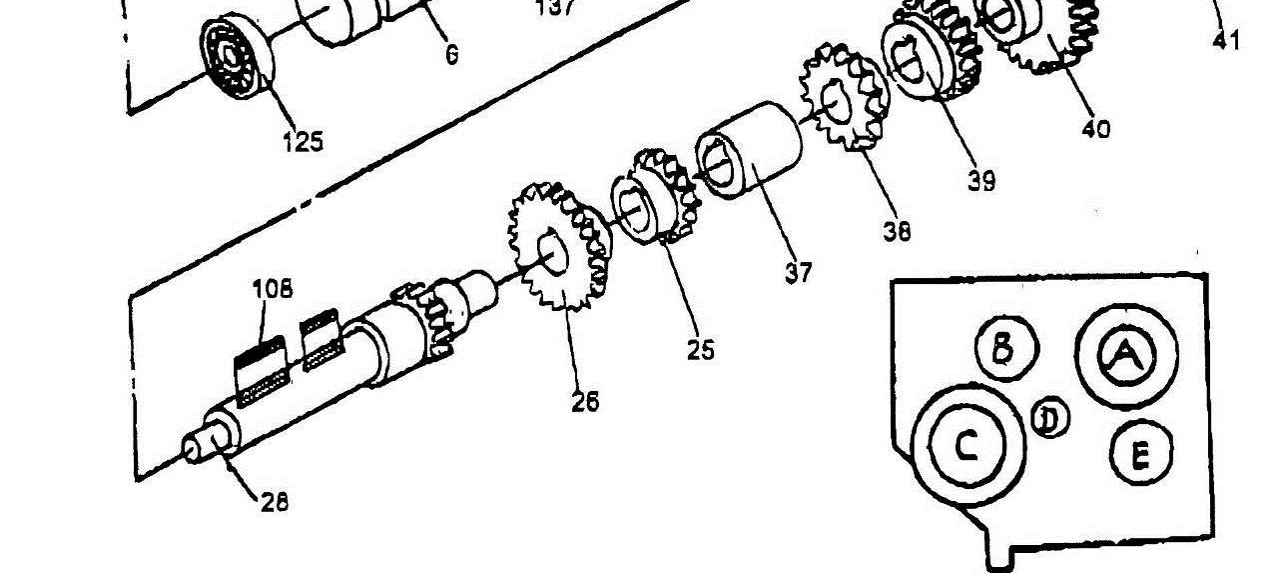


🧑: Where is the lubrication diagram?
🤖: The lubrication diagram is not provided in the text. The text mentions lubrication instructions and refers to a figure (figure 32) for the lubricating oil level window, but the actual diagram is not included in the provided context.

--- Sources ---
• text → data/text/doc2_text_51_1.txt (page 51.0)
• image → data/images/doc2_image_66_4_344.png (page 66.0)
• image → data/images/doc2_image_54_3_248.png (page 54.0)
• image → data/images/doc2_image_60_2_287.png (page 60.0)
• image → data/images/doc2_image_66_2_338.png (page 66.0)


In [37]:
ask("Where is the lubrication diagram?")


In [ ]:
from langchain_pinecone import PineconeVectorStore
from langchain_openai import ChatOpenAI
from langchain.chains import ConversationalRetrievalChain
from langchain.memory import ConversationBufferMemory

# Vector store
vectorstore = PineconeVectorStore(
    index=index,
    embedding=embeddings,
    namespace="v1",
    text_key="text"
)

# Retriever
retriever = vectorstore.as_retriever(search_kwargs={"k": 5})

# LLM
llm = ChatOpenAI(model_name="gpt-4o", temperature=0.2)

# Memory
memory = ConversationBufferMemory(
    memory_key="chat_history",
    return_messages=True,
    output_key="answer"  # ✅ Tells memory what to store
)

# RAG Chain with output key fix
chat_rag = ConversationalRetrievalChain.from_llm(
    llm=llm,
    retriever=retriever,
    memory=memory,
    return_source_documents=True,
    output_key="answer"
)

# Chat loop
def ask(query):
    input_vars = {
        "question": query,
        "chat_history": memory.load_memory_variables({})["chat_history"]  # ✅ now correctly aligned
    }
    res = chat_rag.invoke(input_vars)
    
    print(f"\n🧑: {query}")
    print(f"🤖: {res['answer']}")
    print("--- Sources ---")
    for doc in res["source_documents"]:
        print(f"• {doc.metadata.get('type')} → {doc.metadata.get('path')} (page {doc.metadata.get('page')})")


# Test
ask("What is the recommended spindle speed range?")
ask("Where is the lubrication diagram?")



🧑: What is the recommended spindle speed range?
🤖: I don't know the recommended spindle speed range based on the provided context. You may need to refer to the specific manual or rotation speed plate attached to the machine for detailed information.
--- Sources ---
• text → data/text/doc2_text_13_2.txt (page 13.0)
• text → data/text/doc2_text_28_2.txt (page 28.0)
• text → data/text/doc2_text_46_2.txt (page 46.0)
• text → data/text/doc2_text_13_3.txt (page 13.0)
• text → data/text/doc2_text_28_3.txt (page 28.0)

🧑: Where is the lubrication diagram?
🤖: The lubrication diagram can be found in Figure 39, which shows the lubrication points on the machine.
--- Sources ---
• text → data/text/doc2_text_51_1.txt (page 51.0)
• text → data/text/doc2_text_52_0.txt (page 52.0)
• image → data/images/doc2_image_66_2_338.png (page 66.0)
• image → data/images/doc2_image_66_4_344.png (page 66.0)
• text → data/text/doc2_text_51_0.txt (page 51.0)


In [53]:
index.describe_index_stats(namespace="v1")


{'dimension': 3072,
 'index_fullness': 0.0,
 'metric': 'cosine',
 'namespaces': {'v1': {'vector_count': 750}},
 'total_vector_count': 750,
 'vector_type': 'dense'}

In [42]:
query = "How to adjust spindle speed?"

query_embedding = embeddings.embed_query(query)

res = index.query(
    vector=query_embedding,
    top_k=3,
    namespace="v1",
    include_metadata=True
)

for match in res['matches']:
    print(f"\nScore: {match['score']:.4f}")
    print(f"Type: {match['metadata'].get('type')}")
    print(f"Path: {match['metadata'].get('path')}")



Score: 0.6529
Type: text
Path: data/text/doc2_text_28_2.txt

Score: 0.6057
Type: text
Path: data/text/doc2_text_13_4.txt

Score: 0.5967
Type: text
Path: data/text/doc2_text_28_3.txt


In [43]:
image_matches = [m for m in res['matches'] if m['metadata'].get('type') == 'image']
for img in image_matches:
    print(f"🔍 Image: {img['metadata'].get('path')} → score: {img['score']:.3f}")


In [45]:
from langchain_pinecone import PineconeVectorStore

vectorstore = PineconeVectorStore(
    index      = index,          # your Pinecone index from earlier
    embedding  = embeddings,     # same OpenAIEmbeddings object
    namespace  = "v1",           # must match your upsert namespace
    text_key   = "text"
)


In [54]:
query = "How to lubricate the spindle?"
query_vector = embeddings.embed_query(query)

res = index.query(
    vector=query_vector,
    top_k=3,
    namespace="v1",
    include_metadata=True
)

for match in res['matches']:
    print(f"\nScore: {match['score']:.3f}")
    print(f"Type: {match['metadata'].get('type')}")
    print(f"Page: {match['metadata'].get('page')}")
    print(f"Path: {match['metadata'].get('path')}")
    print(f"Text: {match['metadata'].get('text', '')[:150]}...")




Score: 0.567
Type: text
Page: 51.0
Path: data/text/doc2_text_51_1.txt
Text: ...

Score: 0.550
Type: text
Page: 54.0
Path: data/text/doc2_text_54_1.txt
Text: ...

Score: 0.536
Type: text
Page: 51.0
Path: data/text/doc2_text_51_0.txt
Text: ...


In [ ]:
retriever = vectorstore.as_retriever(search_kwargs={"k": 3})
docs = retriever.invoke("Where is the lubrication diagram?")

for doc in docs:
    print(f"\nType: {doc.metadata.get('type')}")
    print(f"Page: {doc.metadata.get('page')}")
    print(f"Path: {doc.metadata.get('path')}")
    print(f"Content preview: {doc.page_content[:200]}...")


Found document with no `text` key. Skipping.
Found document with no `text` key. Skipping.
Found document with no `text` key. Skipping.


Task exception was never retrieved
future: <Task finished name='Task-2799' coro=<caption_image_async() done, defined at /var/folders/3x/zwytj0k10b1_d1jp5zlhvt7w0000gn/T/ipykernel_12320/159809286.py:35> exception=APIConnectionError('Connection error.')>
Traceback (most recent call last):
  File "/Users/rajeev/anaconda3/lib/python3.11/site-packages/httpx/_transports/default.py", line 72, in map_httpcore_exceptions
    yield
  File "/Users/rajeev/anaconda3/lib/python3.11/site-packages/httpx/_transports/default.py", line 377, in handle_async_request
    resp = await self._pool.handle_async_request(req)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/rajeev/anaconda3/lib/python3.11/site-packages/httpcore/_async/connection_pool.py", line 256, in handle_async_request
    raise exc from None
  File "/Users/rajeev/anaconda3/lib/python3.11/site-packages/httpcore/_async/connection_pool.py", line 236, in handle_async_request
    response = await connection.handle_async_request